In [149]:
import io
import math
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

import seaborn as sns
sns.set()

%matplotlib inline

### Part 0: Setting Up the Data

Loading in and processing our data.

In [2]:
col_data = [("Genre", "|S20"),
            ("Artist", "|S50"),
            ("Track", "|S50"),
            ("Track ID", "|S22"),
            ("Popularity", int),
            ("Acousticness", float),
            ("Danceability", float),
            ("Duration (MS)", int),
            ("Energy", float),
            ("Instrumentalness", float),
            ("Key", "|S2"),
            ("Liveness", float),
            ("Loudness", float),
            ("Mode", int),
            ("Speechiness", float),
            ("Tempo", float),
            ("Time Signature", "|S3"),
            ("Valence", float)]

with io.open("SpotifyFeatures.csv", "r", encoding="utf-8") as f:
    data = np.genfromtxt(f, delimiter=",", skip_header=1, comments=None, dtype=col_data)

With our data loaded in, we can then process the columns to build up our x and y arrays.

The x array represents our data points and is 132096 x 10. The columns are **Acousticness**, **Energy**, **Instrumentalness**, **Key** (normalized between 0 and 1 using the key mapping dictionary defined below), **Liveness**, **Mode** (major or minor represented by 1 or 0, respectively), **Speechiness**, **Tempo** (normalized between 0 and 1), and **Valence**.

The y array represents the true label for each data point and is 132096 x 1. Each genre is mapped to a specific number.

In [126]:
x = np.empty((data.shape[0], 10))
y = np.empty((data.shape[0], 1))
y_genre = [None] * data.shape[0]
genre_mapping_dict = {}
genre_idx = 0

# based on data set. Mapped before processing to allow for proper steps
# 7 notes (ABCDEFG) - 1/7 step between each. 1/14 for sharp notes
key_mappings = {
    "A": 0,
    "A#": 1/14,
    "B": 1/7,
    "C": 2/7,
    "C#": 5/14,
    "D": 3/7,
    "D#": 7/14,
    "E": 4/7,
    "F": 5/7,
    "F#": 11/14,
    "G": 6/7,
    "G#": 13/14
}

for i in range(len(data)):
    row = data[i]
    genre = row[0].decode("utf-8")
    if not genre in genre_mapping_dict:
        genre_mapping_dict[genre] = genre_idx
        genre_idx += 1
    y[i] = genre_mapping_dict[genre]
    y_genre[i] = genre
    
    decoded_key = row[10].decode("utf-8")
    if decoded_key in key_mappings:
        key = key_mappings[decoded_key]
    else:
        key = 1
        
    values = [row[5], row[6], row[8], 
              row[9], key, row[11], row[13], 
              row[14], row[15], row[17]]
    x[i, :] = values

# normalize tempo column
max_tempo = np.max(x[:, 8])
min_tempo = np.min(x[:, 8])
x[:, 8] = (x[:, 8] - min_tempo) / (max_tempo - min_tempo)

### Part 1: Supervised Learning  

Can we predict the genre of a song based on its characteristics? We test five supervised learning methods (linear regression, logistic regression, decision tree, random forest, and a neural network (MLP)).

First, let's split our data into training (90%) and test (10%) sets. We also set up our array to keep track of the accuracy of each method.

In [76]:
# split X and Y into training and test 
TEST_PERCENTAGE = 10

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = TEST_PERCENTAGE / 100, stratify=y)

In [78]:
scores = []

# linear regression
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(x_train, y_train)  # perform linear regression
y_pred = linear_regressor.predict(x_test)
linear_score = linear_regressor.score(x_test, y_test)
print("Linear Regression Score: " + str(linear_score))

scores.append(linear_score)

# logistic regression
logit = LogisticRegression(C = 0.95, solver="sag", multi_class="multinomial", max_iter=500)
fit = logit.fit(x_train, np.ravel(y_train))
logit_score = logit.score(x_test, y_test)
print("Logistic Regression Score: " + str(logit_score))

scores.append(logit_score)

# decision tree
dt = DecisionTreeClassifier(max_depth=14) # 14 genres
dt.fit(x_train, y_train)
dt_score = dt.score(x_test, y_test)
print("Decision Tree Score: " + str(dt_score))

scores.append(dt_score)

# random forest classifier
rf = RandomForestClassifier(n_estimators=100)
rf.fit(x_train, np.ravel(y_train))
rf_score = rf.score(x_test, np.ravel(y_test))
print("Random Forest Score: " + str(rf_score))

scores.append(rf_score)

# multi-layer NN
mlp = MLPClassifier(hidden_layer_sizes=(100,100,100), activation="logistic", max_iter=500, alpha=0.0001,
                    solver='adam', verbose=False, random_state=44, tol=0.001)

mlp.fit(x_train, np.ravel(y_train))
mlp_score = mlp.score(x_test, np.ravel(y_test))
print("MLP Score: " + str(mlp_score))

scores.append(mlp_score)

Linear Regression Score: 0.08508950887027944
Logistic Regression Score: 0.3065102195306586
Decision Tree Score: 0.31400454201362604
Random Forest Score: 0.35806207418622255
MLP Score: 0.3437547312641938


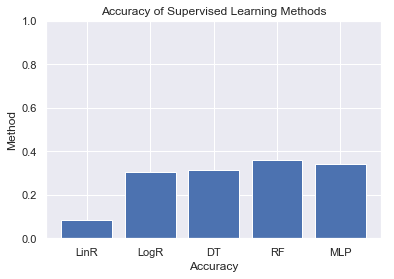

In [93]:
methods = ["LinR", "LogR", "DT", "RF", "MLP"]
plt.title("Accuracy of Supervised Learning Methods")
plt.xlabel("Accuracy")
plt.ylabel("Method")
plt.ylim(0.0, 1.0)
plt.bar(np.arange(5), scores, tick_label=methods)
plt.show()

The best classifier out of the five we tried was Random Forest, but even that did not have a very good accuracy (~36%). The takeaway here is that classifying genres is more complex than using features like acousticness, danceability, etc. This intuitively makes sense - to further increase accuracy, we would need to introduce features like chord progressions and lyrical analyses.

### Part 2: Unsupervised Learning

As seen in the supervised learning section, classifying predefined genres can be difficult given the features we have access to - there can be a lot of overlap, and our features also don't fully capture the differences between genres.

Using unsupervised learning, we'll analyze which features are most important when it comes to classifying genres. We can then attempt to define our own genre clusters based solely on these features.

First, let's take a look at which features are most important using SelectKBest.

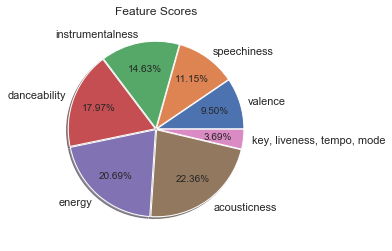

In [114]:
# feature selection
feature_labels = ["acousticness", "danceability", "energy", "instrumentalness", "key", "liveness", "mode", "speechiness", "tempo", "valence"]
feature_selector = SelectKBest()
feature_selector.fit(x, np.ravel(y))
percentages = feature_selector.scores_ / np.sum(feature_selector.scores_)

# reduce any feature < 0.05 into one slice
zip_sort = sorted(zip(percentages, feature_labels))
pie_labels = []
pie_percentages= []
reduced_sum = 0.0
reduced_labels = []
for percent,label in zip_sort:
    if percent < 0.05:
        reduced_sum += percent
        reduced_labels.append(label)
    else:
        pie_percentages.append(percent)
        pie_labels.append(label)

pie_percentages.append(reduced_sum)
pie_labels.append(", ".join(reduced_labels))
plt.title("Feature Scores")
plt.pie(pie_percentages, pctdistance=0.7, explode=np.full(len(pie_labels), 0.01), labels=pie_labels, autopct='%1.2f%%', shadow=True)
plt.show()

Using the default score function (f_classif), we see that Acousticness, Energy, and Danceability are the three most important features. Key, Liveness, Tempo, and Mode are barely influential, if at all.

The next step is to begin defining our own genre clusters using KMeans. First, we use the elbow method to determine the optimal number of clusters given our data.

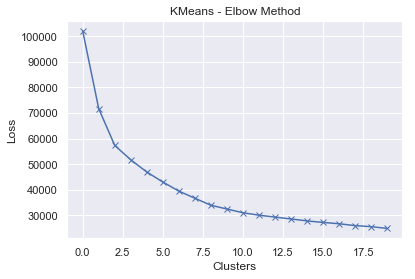

In [115]:
# elbow method
loss = []
max_centers = 20
for i in range(1, max_centers + 1):
    kmeans = KMeans(n_clusters=i, n_jobs=-1).fit(x)
    loss.append(kmeans.inertia_)
    
plt.plot(loss, "x-")
plt.title("KMeans - Elbow Method")
plt.xlabel("Clusters")
plt.ylabel("Loss")
plt.show()

The loss begins to level out around 7-10 clusters. We choose 7 as our optimal cluster number, but a case could be made for 8 clusters as well.

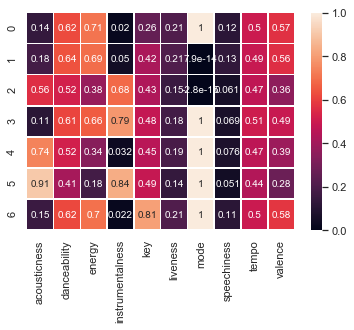

In [132]:
# run kmeans with the optimal number of clusters
kmeans_optimal = KMeans(n_clusters=7, n_jobs=-1, random_state=77).fit(x)
ax = sns.heatmap(kmeans_optimal.cluster_centers_, linewidth=0.5, xticklabels=feature_labels, annot=True)
plt.show()

Each row of the above heat map corresponds to a cluster. Using the values of each center, we can create eight classifications with respect to the actual features instead of specific genre definitions.

Tempo and liveness are fairly similar across all of the clusters, which is consistent with the results of our feature scores. One observation is that centers with higher acousticness and lower energies correspond to relatively lower tempos, which makes sense.

Danceability and energy appear to be positively correlated, and both seem to be negatively correlated with acousticness and valence. Most clusters are in a major key.

We attempt to label these clusters with respect to their features below.

In [146]:
optimal_labels = ["High D, Highest E/V, Lowest I, Low A, C Major",
                  "Highest D, High E/V, Low I/A, D Minor",
                  "Medium D, Low E/V, Medium I/A, D Minor",
                  "High D/E, Medium V, High I, Lowest A, D# Major",
                  "Medium D, Low E/V, Low I, High A, D Major",
                  "Lowest D/E/V, Highest I/A, D# Major",
                  "High D/E/V, Low I/A, F# Major"]

assigned_optimal_labels = [None] * len(kmeans_optimal.labels_)
for i in range(len(kmeans_optimal.labels_)):
    assigned_optimal_labels[i] = optimal_labels[int(kmeans_optimal.labels_[i])]

Next, we run KMeans with the same number of clusters as genres in our original data set (14). This is mostly just for the sake of comparison.

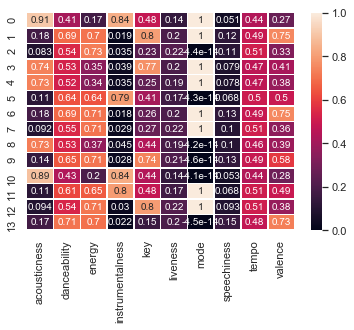

In [134]:
# run kmeans with the number of genres defined by the data set
kmeans_predefined = KMeans(n_clusters=14, n_jobs=-1, random_state=77).fit(x)
ax = sns.heatmap(kmeans_predefined.cluster_centers_, linewidth=0.5, xticklabels=feature_labels, annot=True)
plt.show()

Lastly, we will use PCA to show that defining our own clusters with KMeans results in better clustering than using the predefined genre labels. We reduce our features to 2 components with PCA, then plot with colors first based on our genre labels, and then based on our optimal KMeans clusters.

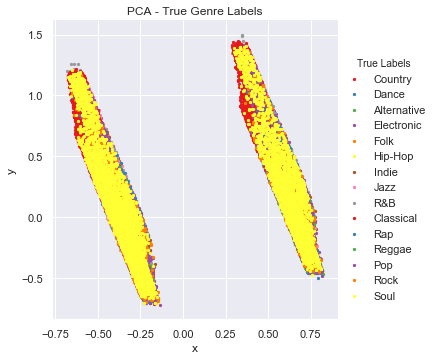

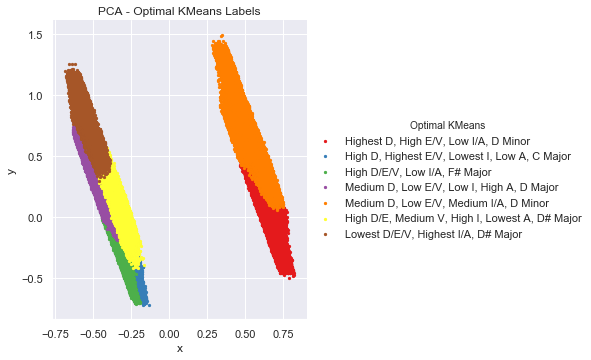

In [148]:
df = pd.DataFrame(data=x,
                  index=np.arange(0, x.shape[0]),
                  columns=["acousticness", "danceability", "energy", "instrumentalness", "key", "liveness", "mode", "speechiness", "tempo", "valence"])

pca = PCA(n_components=2)
reduced_x = pca.fit_transform(x)

df["x"] = reduced_x[:, 0]
df["y"] = reduced_x[:, 1]
df["Optimal KMeans"] = assigned_optimal_labels
df["True Labels"] = y_genre

sns.lmplot(data=df, x="x", y="y", hue="True Labels", fit_reg=False, palette='Set1',
           scatter_kws={'alpha':1, 's':5})
plt.gca().set_title("PCA - True Genre Labels")

sns.lmplot(data=df, x="x", y="y", hue="Optimal KMeans", fit_reg=False, palette='Set1',
           scatter_kws={'alpha':1, 's':5})
plt.gca().set_title("PCA - Optimal KMeans Labels")

plt.show()